# Subsampling verschieden langer Zeitreihen

Suche der besten Subsampling-Länge

Test SVM-Klassifikation


In [ ]:
import io, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy
from sklearn import model_selection, svm, metrics, manifold
import joblib

import prepare

In [2]:
BASE_DIR = 'renamed'
DATA_OK = ['ok', 'near_ok_sonowechsel']
DATA_FEHLER = ['fehler_oel', 'fehler_leitungsversatz', 'fehler_terminversatz']
DATA_ALL = DATA_OK + DATA_FEHLER

In [3]:
DATA_ALL

['ok',
 'near_ok_sonowechsel',
 'fehler_oel',
 'fehler_leitungsversatz',
 'fehler_terminversatz']

In [4]:
zugversuche, kurven = prepare.read_all(BASE_DIR, DATA_ALL)

ok_: count 200 rows 1407...1650
near_ok_sonowechsel_: count 100 rows 1582...1759
fehler_oel_: count 100 rows 1052...1434
fehler_leitungsversatz_: count 100 rows 1716...2403
fehler_terminversatz_: count 100 rows 1702...2092


Debugausgabe

In [5]:
zugversuche

,nr,festigkeit,key,label,label_text
0,1569,2600.000000,ok_1569,0,ok
1,1570,2750.000000,ok_1570,0,ok
2,1571,2770.000000,ok_1571,0,ok
3,1572,2660.000000,ok_1572,0,ok
4,1573,2810.000000,ok_1573,0,ok
...,...,...,...,...,...
595,2505,1479.522827,fehler_terminversatz_2505,4,fehler_terminversatz
596,2506,2085.117920,fehler_terminversatz_2506,4,fehler_terminversatz
597,2507,2237.231201,fehler_terminversatz_2507,4,fehler_terminversatz
598,2508,2406.469482,fehler_terminversatz_2508,4,fehler_terminversatz


Aufteilung in Trainings- und Testdaten

In [6]:
versuche_train, versuche_test = model_selection.train_test_split(zugversuche, test_size=0.2, random_state=42)
versuche_train.shape, versuche_test.shape

((480, 5), (120, 5))

Abtrennen Zielgrößen: Label und Festigkeit

In [34]:
label_train = versuche_train.label.values
festigkeit_train = versuche_train.festigkeit.values

In [35]:
label_test = versuche_test.label.values
festigkeit_test = versuche_test.festigkeit.values


Bewertung Modellqualität (Regression Festigkeit)

In [41]:
def eval_model(prefix, truth, pred):
    mse = metrics.mean_squared_error(truth, pred)
    mae = metrics.mean_absolute_error(truth, pred)
    print(f"{prefix:<10} MSE: {mse:8.1f} RMSE: {np.sqrt(mse):8.1f} MAE: {mae:8.1f}")


Suche beste Subsample-Größe

In [44]:
for subsample_size in (5, 10, 15, 20, 25, 30):
    print("subsample size:", subsample_size)
    subsample2 = prepare.Subsample2(subsample_size)
    subsample2.fit() # dummy
    tsMaxScale = prepare.TsMaxScaler()
    X_train = subsample2.transform(versuche_train.key, kurven)
    X_train_scaled = tsMaxScale.fit_transform(X_train)
    X2_train = X_train_scaled[:,:,0]
    params = {
        #'C': scipy.stats.expon(100),
        #'gamma': scipy.stats.expon(0.01),
        'C': np.logspace(0, 4),      # 50 Werte zwischen 1 und 10000
        'gamma': np.logspace(-5, 1), # 50 Werte zwischen 1e-5 und 10
    }
    estim2 = model_selection.RandomizedSearchCV(
        svm.SVR(),
        params,
        n_iter=30,
    )
    estim2.fit(X2_train, festigkeit_train)
    print('Best paramaters:', estim2.best_params_)
    best_estim = estim2.best_estimator_

    X_test = subsample2.transform(versuche_test.key, kurven)
    X_test_scaled = tsMaxScale.transform(X_test)
    X2_test = X_test_scaled[:,:,0]
    pred_train = best_estim.predict(X2_train)
    eval_model('Train', festigkeit_train, pred_train)

subsample size: 5
Best paramaters: {'gamma': 7.543120063354607, 'C': 159.98587196060572}
Train      MSE:  28751.2 RMSE:    169.6 MAE:    115.7
subsample size: 10
Best paramaters: {'gamma': 7.543120063354607, 'C': 281.1768697974228}
Train      MSE:  23072.8 RMSE:    151.9 MAE:    101.8
subsample size: 15
Best paramaters: {'gamma': 10.0, 'C': 4714.8663634573895}
Train      MSE:  10788.4 RMSE:    103.9 MAE:     67.6
subsample size: 20
Best paramaters: {'gamma': 1.389495494373136, 'C': 1048.1131341546852}
Train      MSE:  22720.9 RMSE:    150.7 MAE:    100.2
subsample size: 25
Best paramaters: {'gamma': 10.0, 'C': 4714.8663634573895}
Train      MSE:   8437.8 RMSE:     91.9 MAE:     53.0
subsample size: 30
Best paramaters: {'gamma': 4.291934260128778, 'C': 1526.4179671752318}
Train      MSE:  12731.8 RMSE:    112.8 MAE:     73.3


Bewerten Testdaten mit bestem Modell

In [53]:
subsample2 = prepare.Subsample2(25)
subsample2.fit() # dummy
tsMaxScale = prepare.TsMaxScaler()
X_train = subsample2.transform(versuche_train.key, kurven)
X_train_scaled = tsMaxScale.fit_transform(X_train)
X2_train = X_train_scaled[:,:,0]
X_test = subsample2.transform(versuche_test.key, kurven)
X_test_scaled = tsMaxScale.transform(X_test)
X2_test = X_test_scaled[:,:,0]
X2_train.shape, X2_test.shape

((480, 25), (120, 25))

In [46]:
def class_curves(X, ax, y, field):
    color = ['black', 'blue', 'red', 'green', 'cyan']
    ti = np.arange(0, X.shape[1]) # Zeitschritte
    for i in range(X.shape[0]):
        #print(X[i,:,ax])
        plt.plot(ti, X[i,:,ax], c=color[y[i]], linewidth=0.5, alpha=0.5)
    handles = [
        matplotlib.lines.Line2D([0], [0], color='black', label='ok'),
        matplotlib.lines.Line2D([0], [0], color='blue', label='ok_wechsel'),
        matplotlib.lines.Line2D([0], [0], color='red', label='oel'),
        matplotlib.lines.Line2D([0], [0], color='green', label='leitung'),
        matplotlib.lines.Line2D([0], [0], color='cyan', label='termin'),
    ]
    plt.legend(handles=handles)

Anzeige Kurven zur Kontrolle.

Text(0.5, 1.0, 'Komplette Kurve auf 25 Zeitpunkte in gleichem Abstand approximiert')

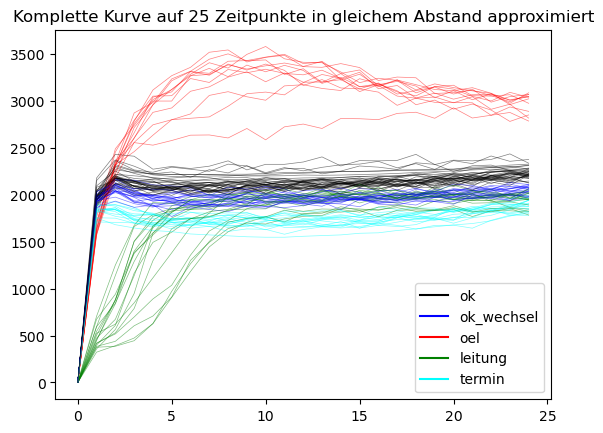

In [48]:
class_curves(X_train[:100,:,:], 0, label_train[:100], 'power')
plt.title("Komplette Kurve auf 25 Zeitpunkte in gleichem Abstand approximiert")

Kontrollanzeige t-SNE

In [49]:
X_train_projected = manifold.TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_train_scaled[:,:,0])

Text(0.5, 1.0, '2-D-Projektion Zeitreihe Power (t-SNE): Klassen')

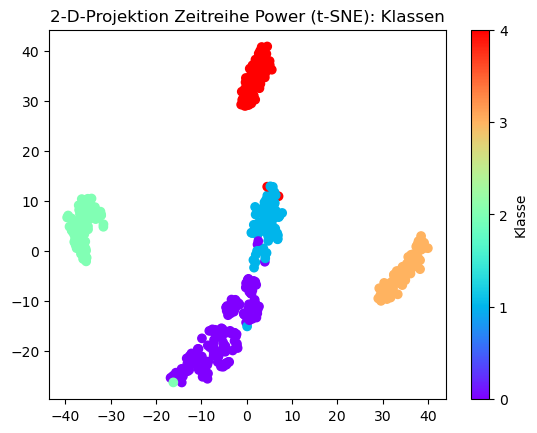

In [50]:
plt.scatter(X_train_projected[:,0], X_train_projected[:,1], c=label_train, cmap='rainbow')
plt.colorbar(label='Klasse', ticks=[0,1,2,3,4,5])
plt.title('2-D-Projektion Zeitreihe Power (t-SNE): Klassen')

Text(0.5, 1.0, '2-D-Projektion Zeitreihe Power (t-SNE): Festigkeit')

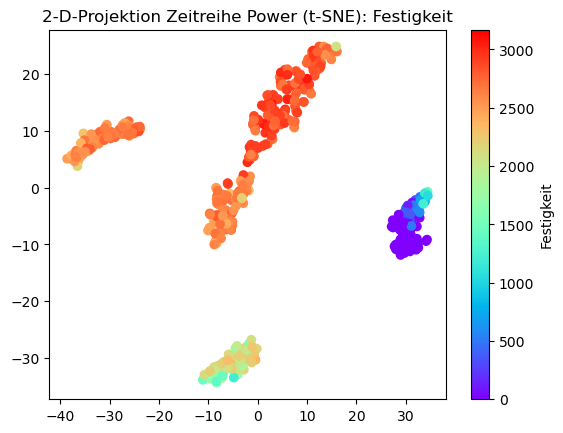

In [16]:
plt.scatter(X_train_projected[:,0], X_train_projected[:,1], c=festigkeit_train, cmap='rainbow')
plt.colorbar(label='Festigkeit')
plt.title('2-D-Projektion Zeitreihe Power (t-SNE): Festigkeit')

Kernel-SVM (Klassifikation) mit Standard-Parametern

In [55]:
estimator = svm.SVC()
_ = estimator.fit(X2_train, label_train)

Accuracy

In [56]:
score_train = estimator.score(X2_train, label_train)
score_test = estimator.score(X2_test, label_test)
score_train, score_test

(0.9791666666666666, 0.9833333333333333)

Anzeige Confusion Matrix (Testdaten)

In [57]:
def plot_confusion(y_true, y_pred):
    conf = metrics.confusion_matrix(y_true, y_pred)
    sns.heatmap(conf, annot=True)
    plt.xlabel('predict')
    plt.ylabel('truth')

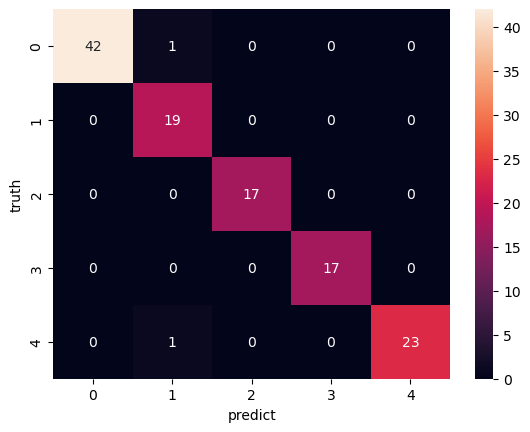

In [58]:
pred_test = estimator.predict(X2_test)
plot_confusion(label_test, pred_test)
plt.savefig('svc_test_confusion.png')

SVM-Regressor (Standardparameter)

In [61]:
regr = svm.SVR(gamma=10.0, C=4714.8663634573895)
_= regr.fit(X2_train, festigkeit_train)

Bewertung Modell mit Testdaten

In [65]:
y_pred_test = regr.predict(X2_test)
eval_model('Test', festigkeit_test, y_pred_test)

Test       MSE:  16617.9 RMSE:    128.9 MAE:     90.9


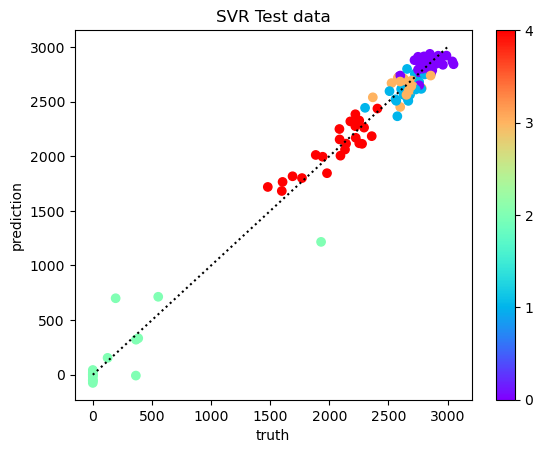

In [68]:
#y_pred_test = regr.predict(X2_test)
plt.scatter(festigkeit_test, y_pred_test, c=label_test, cmap='rainbow')
plt.plot([0, 3000], [0,3000], "k:")
plt.title('SVR Test data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5))
plt.savefig('svr_test.png')

In [70]:
joblib.dump({
    'subsample_len': 25,
    'scaler': tsMaxScale,
    'svc': estimator,
    'svr': regr,
}, 'svr3.joblib')

['svr3.joblib']